# Data Selection & Analysis

In [23]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from src.utils import *

# pandas settings
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# seaborn setting
sns.set_style("white")
sns.set_palette("colorblind")

# set up autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the data

In [24]:
PATH_TO_DATA_FILE = None

# Load the data
df = pd.read_csv(PATH_TO_DATA_FILE)
print("There are {} patients in the dataset.".format(df.user.nunique()))

# Transform date column to datetime type
df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")

# Keep only the pre-lockdown and lock-down period
df = df[df["period"].isin(["Pre-Lockdown", "Lockdown"])]

# Sort by patient id and date (just for convenience)
df.sort_values(by=["user", "date"], ascending=[True, True], inplace=True)

# Drop patients without anxiety score
pids_to_drop = [pid for pid in df.user.unique() if df[df.user==pid]["Anxiety_Group"].isna().all()]
df = df[~df.user.isin(pids_to_drop)]

print("There are {} patients in the dataset after filtering out those without anxiety score.".format(df.user.nunique()))


There are 146 patients in the dataset.
There are 144 patients in the dataset after filtering out those without anxiety score.


In [25]:
df.head()

,user,date,period,Communication,nCommunication,Social,nSocial,Anxiety_Group,Sex,Age,Lives_Alone,CurrentActivity,Covid25,Covid34,Covid37,Covid43,GAD7_SUM
11,582,2020-02-01,Pre-Lockdown,193.000,5.263,nan,nan,Non-Clinical Anxiety,Mujer,46,No,Desempleado(a) con beneficio,Buena,No,Extremadamente,Un poco más,8
23,582,2020-02-02,Pre-Lockdown,1186.000,7.078,nan,nan,Non-Clinical Anxiety,Mujer,46,No,Desempleado(a) con beneficio,Buena,No,Extremadamente,Un poco más,8
14,582,2020-02-03,Pre-Lockdown,979.000,6.887,nan,nan,Non-Clinical Anxiety,Mujer,46,No,Desempleado(a) con beneficio,Buena,No,Extremadamente,Un poco más,8
3,582,2020-02-04,Pre-Lockdown,982.000,6.890,nan,nan,Non-Clinical Anxiety,Mujer,46,No,Desempleado(a) con beneficio,Buena,No,Extremadamente,Un poco más,8
2,582,2020-02-05,Pre-Lockdown,1307.000,7.175,nan,nan,Non-Clinical Anxiety,Mujer,46,No,Desempleado(a) con beneficio,Buena,No,Extremadamente,Un poco más,8


## Temporal variables

In [26]:
# Select the temporal variables of interest - now we focus on nCommunication, which is the log-Communication
df_temp = df[["user", "date", "period", "nCommunication", "nSocial", "Anxiety_Group"]].copy()

# Remove patients without communication data
df_temp = remove_groups_without_data(df_temp, "user", ["nCommunication"])

# Remove patients without social usage data
df_temp = remove_groups_without_data(df_temp, "user", ["nSocial"])

print(
    "{} patients left after removing patients without any communication or social app usage data.".format(
        df_temp.user.nunique()
    )
)

# Remove patients without data in both pre-lockdown and lockdown periods
pids_to_discard = []
for pid in df_temp.user.unique():
    df_patient = df_temp[df_temp.user == pid]
    # if patient only has pre-lockdown or lockdown data
    if df_patient.period.nunique() != 2:
        pids_to_discard.append(pid)
    # if patient doesn't have at least one observation for each variable in both periods
    else:
        df_pre = df_patient[df_patient.period == "Pre-Lockdown"]
        df_lck = df_patient[df_patient.period == "Lockdown"]
        if ((df_pre.nSocial.isna().all() or df_pre.nCommunication.isna().all())
                or (df_lck.nSocial.isna().all() or df_lck.nCommunication.isna().all())):
            pids_to_discard.append(pid)

df_temp = df_temp[~df_temp.user.isin(pids_to_discard)]

print(
    "There are {} patients that don't have lockdown data.\nThese will be discarded from further analysis. Hence we are left with {} patients in the dataset.".format(
        len(pids_to_discard), df_temp.user.nunique()
    )
)

# Resample the data, just to make sure no dates as missing
df_temp = resample_dates(df_temp, "user")

123 patients left after removing patients without any communication or social app usage data.
There are 28 patients that don't have lockdown data.
These will be discarded from further analysis. Hence we are left with 95 patients in the dataset.


#### No. of patient sequences and their length

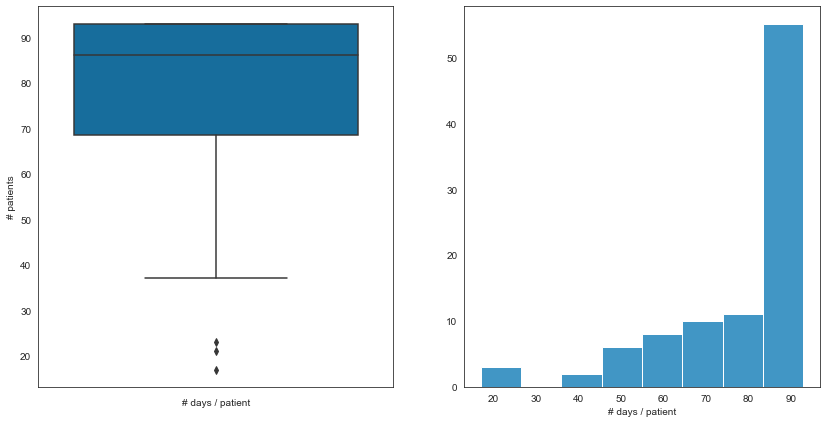

In [27]:
sl_count = df_temp.user.value_counts()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
sns.boxplot(y=sl_count, ax=ax1)
ax1.set_xlabel("# days / patient")
ax1.set_ylabel("# patients")

sns.histplot(data=sl_count, ax=ax2)
ax2.set_xlabel("# days / patient")
ax2.set_ylabel("");

#### Missing communication observations

In [28]:
percent_missing = (df_temp.nCommunication.isna().sum() / len(df_temp)) * 100
print( "{:.3f} % of the communication data is missing".format(percent_missing))

percent_missing = (df_temp.nSocial.isna().sum() / len(df_temp)) * 100
print( "{:.3f} % of the social usage data is missing".format(percent_missing))

8.761 % of the communication data is missing
30.257 % of the social usage data is missing


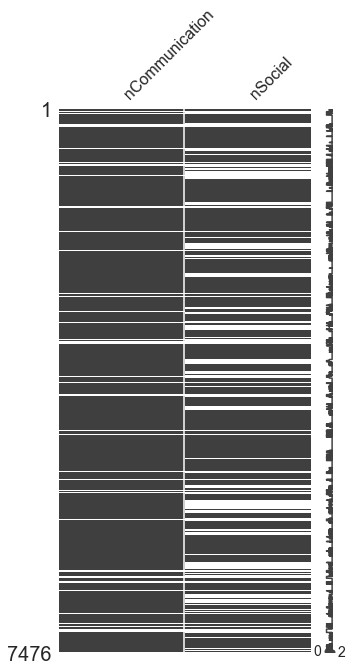

In [29]:
msno.matrix(df_temp[["nCommunication", "nSocial"]], figsize=(5, 10));

#### Data distribution

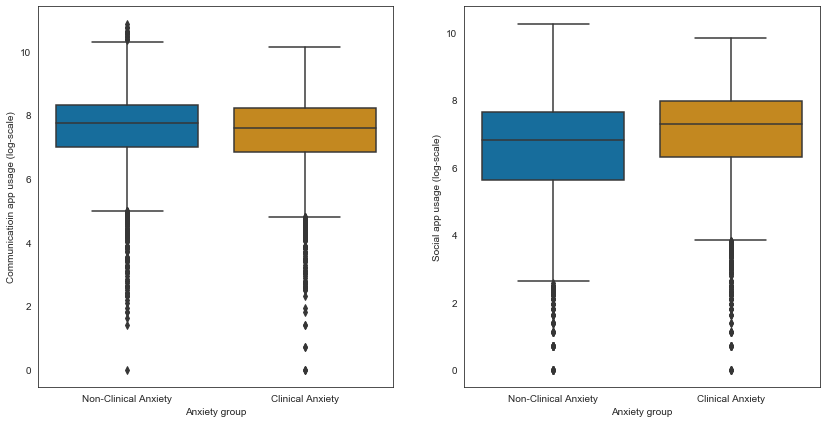

In [30]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
sns.boxplot(y="nCommunication", x="Anxiety_Group", data=df_temp, ax=ax1)
ax1.set(xlabel = "Anxiety group", ylabel="Communicatioin app usage (log-scale)")

sns.boxplot(y="nSocial", x="Anxiety_Group", data=df_temp, ax=ax2)
ax2.set(xlabel = "Anxiety group", ylabel="Social app usage (log-scale)")

### Scale and save the imputed dataframe

In [31]:
# Standardise the communication data
com_scaler = StandardScaler().fit(df_temp[["nCommunication", "nSocial"]].values.reshape(-1, 2))
df_temp[["nCommunication", "nSocial"]] = com_scaler.transform(
    df_temp[["nCommunication", "nSocial"]].values.reshape(-1, 2)
)

## Missing data imputation

### Impute missing communication entries per patient

In [32]:
df_imp = df_temp.copy()

# Mean / patient
df_imp["comm_mean"] = df_imp[["user", "nCommunication"]].groupby("user").transform(lambda x: x.fillna(x.mean()))

# Median / patient
df_imp["comm_med"] = df_imp[["user", "nCommunication"]].groupby("user").transform(lambda x: x.fillna(x.median()))

# Forward fill / patient
df_imp["comm_ffill"] = df_imp[["user", "nCommunication"]].groupby("user").transform(lambda x: x.fillna(method='ffill'))

# Backward fill / patient
df_imp["comm_bfill"] = df_imp[["user", "nCommunication"]].groupby("user").transform(lambda x: x.fillna(method='bfill'))

# Linear interpolation / patient
df_imp["comm_lin"] = df_imp[["user", "nCommunication"]].groupby("user").transform(lambda x: x.interpolate(method='linear', 
                                                                                                      limit_direction='forward', axis=0))

* **Distribution of the communication data after each type of imputation**

The variability is minimal, this indicates that any of these is a good choice. We will work with the median, because that is a robust measure.

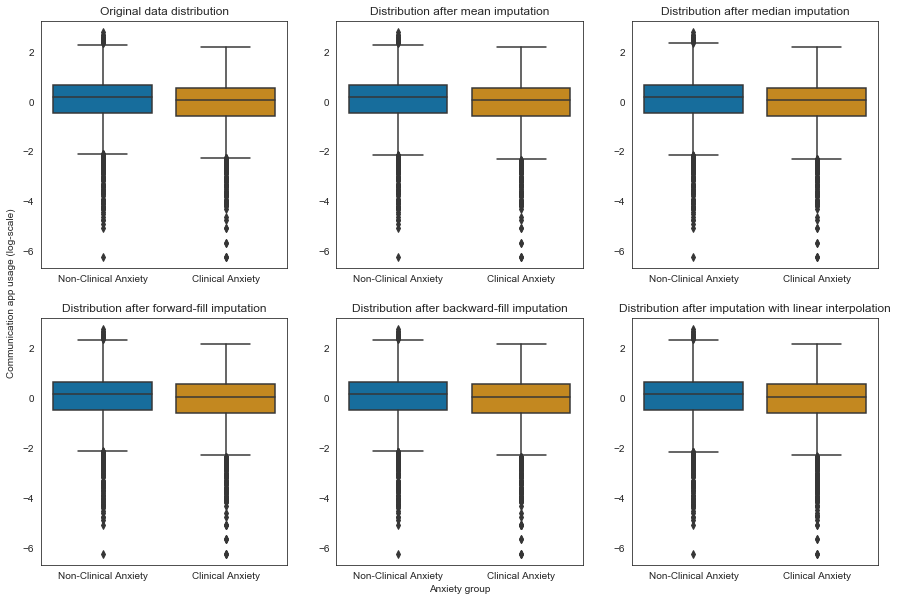

In [33]:
comm_cols = ["nCommunication", "comm_mean", "comm_med", "comm_ffill", "comm_bfill", "comm_lin"]
title_cols = ["Original data distribution", "Distribution after mean imputation", "Distribution after median imputation",
              "Distribution after forward-fill imputation", "Distribution after backward-fill imputation",
              "Distribution after imputation with linear interpolation"]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for idx, ax in enumerate(axs.ravel()):
    sns.boxplot(y=comm_cols[idx], x="Anxiety_Group", data=df_imp, ax=ax)
    ax.set(xlabel="", ylabel="", title=title_cols[idx])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Anxiety group")
plt.ylabel("Communication app usage (log-scale)")

In [34]:
df_imp[["nCommunication", "comm_mean", "comm_med", "comm_ffill", "comm_bfill", "comm_lin"]].describe()

,nCommunication,comm_mean,comm_med,comm_ffill,comm_bfill,comm_lin
count,6821.000,7476.000,7476.000,7475.000,7456.000,7475.000
mean,-0.000,-0.017,-0.004,-0.057,-0.045,-0.053
std,1.000,0.976,0.976,1.071,1.056,1.037
min,-6.224,-6.224,-6.224,-6.224,-6.224,-6.224
25%,-0.487,-0.510,-0.506,-0.578,-0.550,-0.574
50%,0.135,0.099,0.128,0.108,0.098,0.098
75%,0.634,0.604,0.619,0.626,0.634,0.617
max,2.791,2.791,2.791,2.791,2.791,2.791


### Impute missing social entries per patient

In [35]:
# Mean / patient
df_imp["social_mean"] = df_imp[["user", "nSocial"]].groupby("user").transform(lambda x: x.fillna(x.mean()))

# Median / patient
df_imp["social_med"] = df_imp[["user", "nSocial"]].groupby("user").transform(lambda x: x.fillna(x.median()))

# Forward fill / patient
df_imp["social_ffill"] = df_imp[["user", "nSocial"]].groupby("user").transform(lambda x: x.fillna(method='ffill'))

# Backward fill / patient
df_imp["social_bfill"] = df_imp[["user", "nSocial"]].groupby("user").transform(lambda x: x.fillna(method='bfill'))

# Linear interpolation / patient
df_imp["social_lin"] = df_imp[["user", "nSocial"]].groupby("user").transform(lambda x: x.interpolate(method='linear', 
                                                                                                       limit_direction='forward', axis=0))

df_imp[["date", "user", "Anxiety_Group", "comm_med", "social_med"]].to_csv("../data/sc_imp_temp_data.csv", index=False)

* **Distribution of the social app data after each type of imputation**

The variability is more significant, due to the larger amount of missing data. We will work with the median, because that is a robust measure and it seems to have scewed the distribution the least.

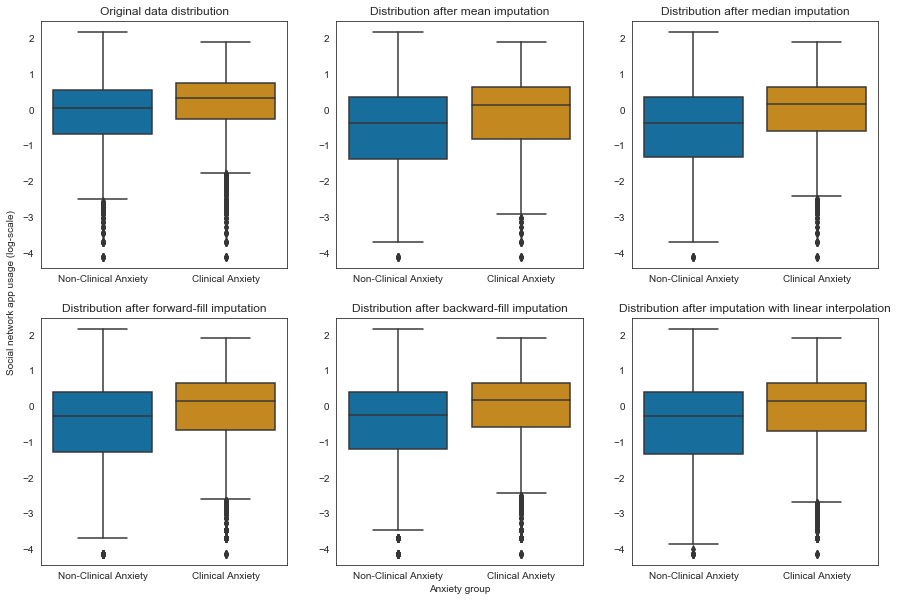

In [36]:
comm_cols = ["nSocial", "social_mean", "social_med", "social_ffill", "social_bfill", "social_lin"]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for idx, ax in enumerate(axs.ravel()):
    sns.boxplot(y=comm_cols[idx], x="Anxiety_Group", data=df_imp, ax=ax)
    ax.set(xlabel="", ylabel="", title=title_cols[idx])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Anxiety group")
plt.ylabel("Social network app usage (log-scale)")

In [37]:
df_imp[["nSocial", "social_mean", "social_med", "social_ffill", "social_bfill", "social_lin"]].describe()


,nSocial,social_mean,social_med,social_ffill,social_bfill,social_lin
count,5214.000,7476.000,7476.000,7334.000,7281.000,7334.000
mean,0.000,-0.356,-0.320,-0.379,-0.329,-0.360
std,1.000,1.138,1.133,1.244,1.207,1.189
min,-4.113,-4.113,-4.113,-4.113,-4.113,-4.113
25%,-0.461,-1.225,-1.040,-1.099,-0.985,-1.102
50%,0.206,-0.133,-0.080,-0.059,-0.039,-0.066
75%,0.667,0.545,0.546,0.536,0.551,0.527
max,2.174,2.174,2.174,2.174,2.174,2.174


### Non-temporal variables

In [38]:
# Select non-temporal variables of interest
df_nt = df[["user", "Anxiety_Group", "GAD7_SUM", "Sex", "Lives_Alone", "CurrentActivity", "Covid25", "Covid34",
            "Covid37", "Covid43", "Age"]].copy()

# Remove duplicates, if any
df_nt.drop_duplicates(inplace=True)

# Drop patients that aren't in the temporal data
df_nt = df_nt[df_nt.user.isin(df_temp.user.unique())]

df_nt.head()

,user,Anxiety_Group,GAD7_SUM,Sex,Lives_Alone,CurrentActivity,Covid25,Covid34,Covid37,Covid43,Age
216,1888,Non-Clinical Anxiety,4,Mujer,No,Incapacidad permanente,Buena,NaN,NaN,Mucho menos,58
270,4170,Clinical Anxiety,10,Mujer,No,Desempleado(a) con beneficio,Buena,Si,Mucho,Un poco menos,24
447,5995,Non-Clinical Anxiety,5,Varon,No,Desempleado(a) con beneficio,Buena,No,Mucho,Más o menos lo mismo,31
460,6050,Non-Clinical Anxiety,7,Mujer,No,Desempleado(a) y sin beneficio,Mala,No,Moderadamente,Más o menos lo mismo,56
591,7053,Clinical Anxiety,15,Varon,No,Activo / ama de casa / estudiante,Buena,Si,Mucho,Un poco menos,27


#### Encode categorical values

| Attribute | Original Values | Encoded Values |
| --- | --- | --- |
| anxiety_group | ['Non-clinical anxiety', 'Clinical anxiety'] | [0, 1] |
| sex | ['Mujer', 'Varon'] | [0, 1] |
| lives_alone|['No', 'Si'] | [0, 1]|
| curr_act| ['NaN', 'Activo / ama de casa / estudiante', 'Desempleado(a) con beneficio', 'Desempleado(a) y sin beneficio', 'Incapacidad temporal', 'Incapacidad permanente',  'Jubilado(a)'] | [0, 1, 2, 3, 4, 5, 6] |
| covid25 (health status)| ['NaN', 'Mala', 'Muy buena', 'Regular', 'Buena', 'Excelente ']|[0, 1, 2, 3] |
| covid34 (presence of essential worker in the household)| ['NaN', 'No', 'Si']|[0, 1, 2] |
| covid37 (how worried are you about the life instability)| ['NaN', 'Nada en absoluto ', 'Ligeramente ', 'Moderadamente ', 'Mucho ', 'Extremadamente ']| [0, 1, 2, 3, 4, 5]|
| covid43 (changes in frequency of social interactions)| ['NaN', 'Mucho menos ', 'Un poco menos ', 'Más o menos lo mismo ', 'Un poco más ', 'Mucho más']| [0, 1, 2, 3, 4, 5]|

In [39]:
ema_cols = ["Anxiety_Group", "Sex", "Lives_Alone", "CurrentActivity", "Covid25", "Covid34", "Covid37", "Covid43"]
df_nt_enc = clinical_data_encoder(df_nt)

# Standardise age
age_scaler = StandardScaler().fit(df_nt["Age"].values.reshape(-1, 1))
df_nt_enc["sc_age"] = age_scaler.transform(df_nt_enc["Age"].values.reshape(-1, 1))

df_nt_enc.head()

,user,Anxiety_Group,GAD7_SUM,Sex,Lives_Alone,CurrentActivity,Covid25,Covid34,Covid37,Covid43,Age,sc_age
216,1888,0,4,0,0,5,3,0,0,1,58,0.858
270,4170,1,10,0,0,2,3,2,4,1,24,-1.356
447,5995,0,5,1,0,2,3,1,4,2,31,-0.900
460,6050,0,7,0,0,3,1,1,3,2,56,0.728
591,7053,1,15,1,0,1,3,2,4,1,27,-1.161


#### Data distributions

* **GAD**

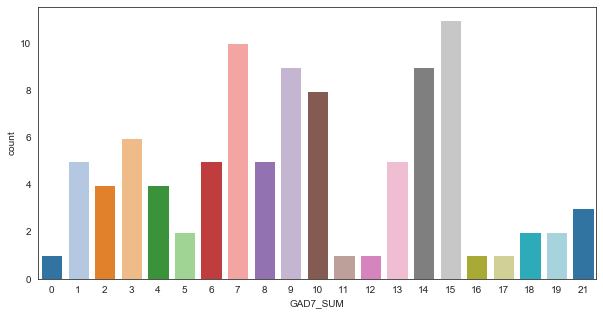

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.countplot(x="GAD7_SUM", data=df_nt, ax=ax, palette="tab20");

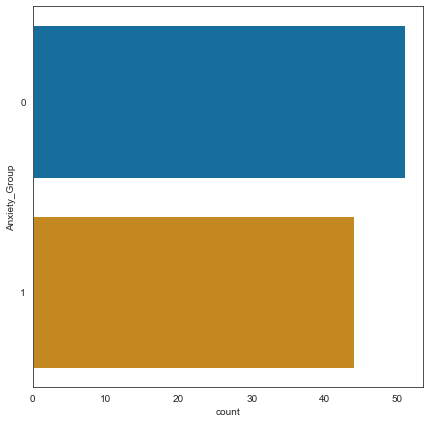

In [42]:
_, ax = plt.subplots(1,1,figsize=(7,7))

sns.countplot(y="Anxiety_Group", data=df_nt, ax=ax);

## Correlations

The data of the selected N = 95 patients across all periods are used to compute the correlations.

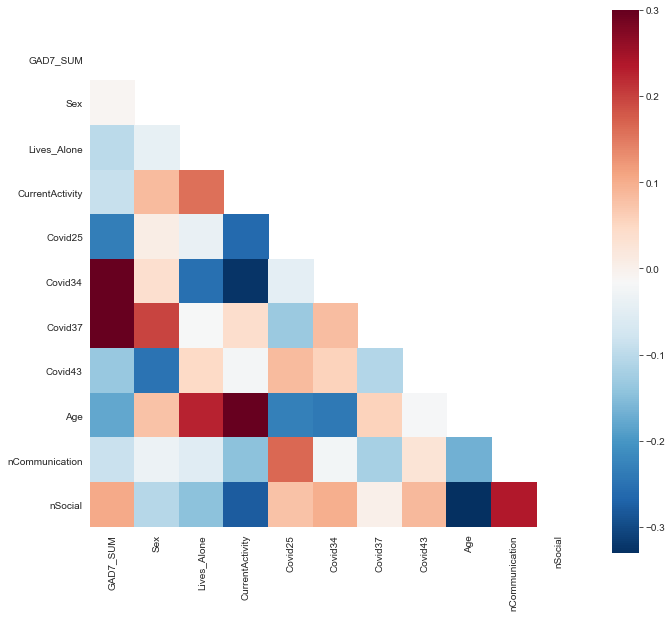

In [43]:
df_data = pd.merge(df_temp[["user", "nCommunication", "nSocial"]] , df_nt_enc , on=["user"], how="inner")
df_data.head()
corr = df_data[["GAD7_SUM"] + ema_cols[1:]+["Age", "nCommunication", "nSocial"]].astype('float').corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(11, 10))
    _ = sns.heatmap(corr, mask=mask, vmax=.3, square=True, cmap="RdBu_r")


## All patient data grouped by anxiety type

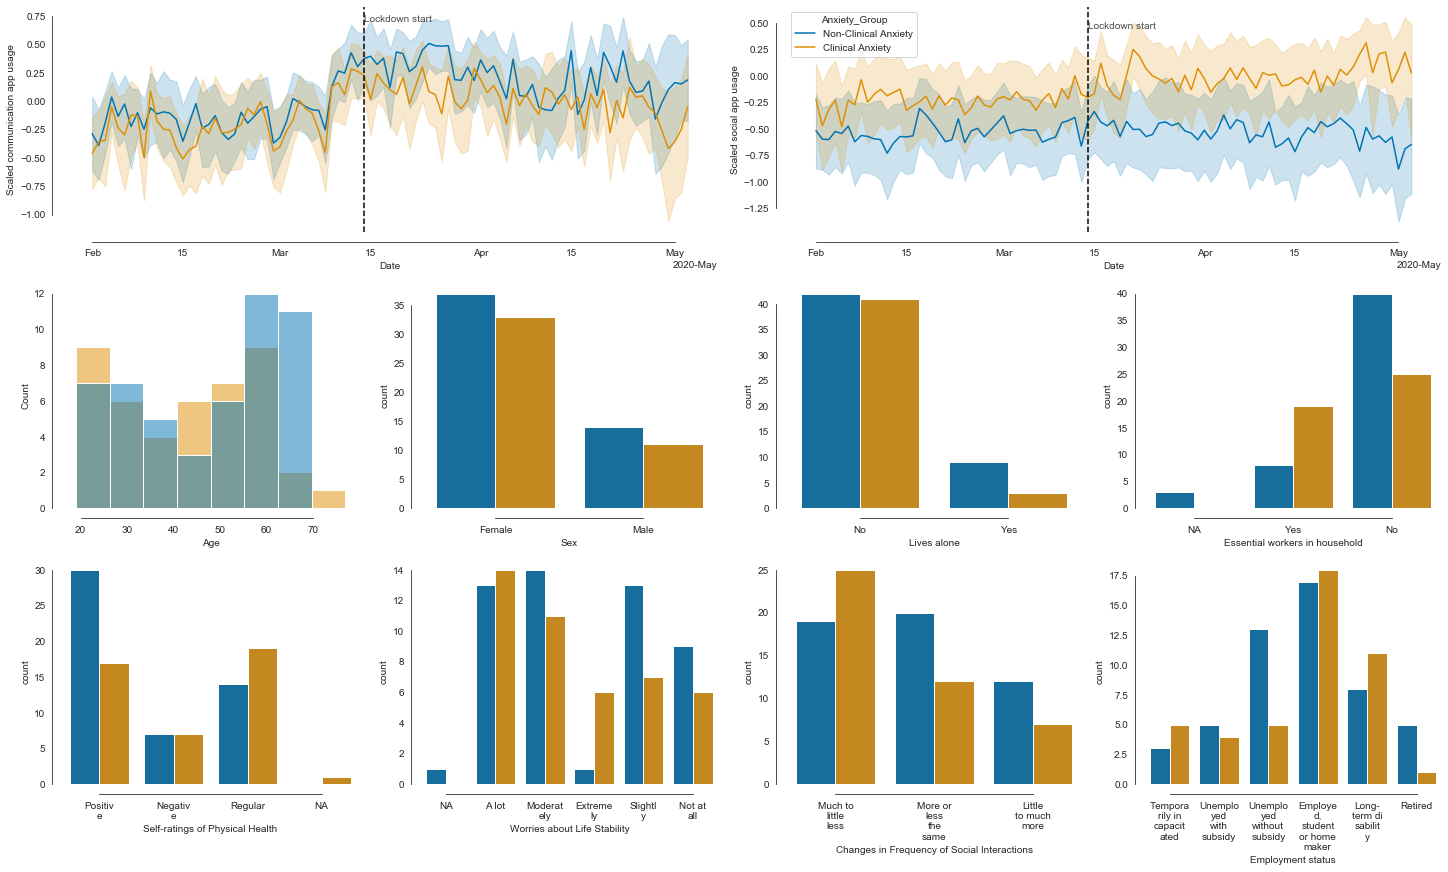

In [44]:
df_nt = clinical_data_decoder(df_nt)
nt_cols = [
    "Sex",
    "Lives alone",
    "Essential workers in household",
    "Self-ratings of Physical Health",
    "Worries about Life Stability",
    "Changes in Frequency of Social Interactions",
    "Employment status",
]

plot_all_data_per_groups(df_imp, df_nt, nt_cols, figsize=(20, 12))